## Import Dependencies

In [4]:
# Randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Image processing and data manipulation
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Deep learning core and utilities
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# ImageFolder and data augumentation
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, ToTensor, RandomAffine

# Learning rate schedulers
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno
import kagglehub

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

## Architecture Class

In [5]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

        self.history_metrics = {'accuracy': [], 'precision': [], 'recall': []}

        self.best_val_loss = float('inf')
        self.tolerance = 0

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, patience=7, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            metrics = self.compute_metrics(self.val_loader)
            self.history_metrics['accuracy'].append(metrics['accuracy'])
            self.history_metrics['precision'].append(metrics['precision'])
            self.history_metrics['recall'].append(metrics['recall'])

            print(f"Val Accuracy: {metrics['accuracy']*100:.2f}% | Precision: {metrics['precision']:.2f} | Recall: {metrics['recall']:.2f}")


            self.best_val_loss, self.tolerance, stop = self.should_early_stop(val_loss, self.best_val_loss, self.tolerance, patience)
            if stop:
                print(f"Early stopping triggered at epoch {self.total_epochs}")
                break


    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def compute_metrics(self, loader):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.to(self.device)
                outputs = self.model(x)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds.cpu())
                all_labels.append(y.cpu())

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        cm = torch.zeros(self.model.fc2.out_features, self.model.fc2.out_features, dtype=torch.int32)
        for t, p in zip(all_labels, all_preds):
            cm[t.long(), p.long()] += 1

        accuracy = (all_preds == all_labels).float().mean().item()

        epsilon = 1e-7
        precision = torch.diag(cm) / (cm.sum(0) + epsilon)
        recall = torch.diag(cm) / (cm.sum(1) + epsilon)

        metrics = {
            'accuracy': accuracy,
            'precision': precision.mean().item(),
            'recall': recall.mean().item(),
            'confusion_matrix': cm
        }
        return metrics

    def evaluate_on_test_set(self, test_loader, class_names=None):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                outputs = self.model(x)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        # Classification Report
        report = classification_report(all_labels, all_preds, target_names=class_names)
        print("Classification Report:\n")
        print(report)

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.history_metrics['accuracy'], label='Val Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy over Epochs')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        return fig

    def should_early_stop(self, val_loss, best_val_loss, tolerance, patience):
        if val_loss < best_val_loss:
            return val_loss, 0, False
        else:
            tolerance += 1
            stop = tolerance >= patience
            return best_val_loss, tolerance, stop

    def layer_parameter_counts(self, by_submodule=True):
        counts = {}
        for name, param in self.model.named_parameters():
            if not param.requires_grad:
                continue
            key = name.split('.')[0] if by_submodule else name
            counts[key] = counts.get(key, 0) + param.numel()
        return counts


## Dataset overview

In [6]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

train_path = os.path.join(path, "Training")
test_path = os.path.join(path, "Testing")

categories = os.listdir(train_path)
print("Subpastas:", categories)

Subpastas: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [7]:
def get_average_image_size(data_path):
    widths = []
    heights = []

    categories = os.listdir(data_path)

    print("Calculating medium size of images...")

    for category in tqdm(categories, desc="Categorias"):
        category_path = os.path.join(data_path, category)
        if not os.path.isdir(category_path):
            continue

        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Erro ao abrir {file_path}: {e}")

    avg_width = sum(widths) / len(widths) if widths else 0
    avg_height = sum(heights) / len(heights) if heights else 0

    return avg_width, avg_height


In [8]:
avg_w, avg_h = get_average_image_size(train_path)
print(f"Tamanho médio das imagens: {avg_w:.2f} x {avg_h:.2f}")

Calculating medium size of images...


Categorias: 100%|██████████| 4/4 [00:23<00:00,  5.96s/it]

Tamanho médio das imagens: 451.56 x 453.88


In [9]:
target_size = (256, 256)
random_state = 42
batch_size = 32
num_classes = 4

label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}



In [10]:
def display_images(dataset_path, num_images=4, image_size=(256, 256)):

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)

        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    return fig

def plot_class_distribution(dataset_path, dataset_type):
    counts = [len(os.listdir(os.path.join(dataset_path, cat))) for cat in categories]

    fig, ax = plt.subplots()
    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    return fig

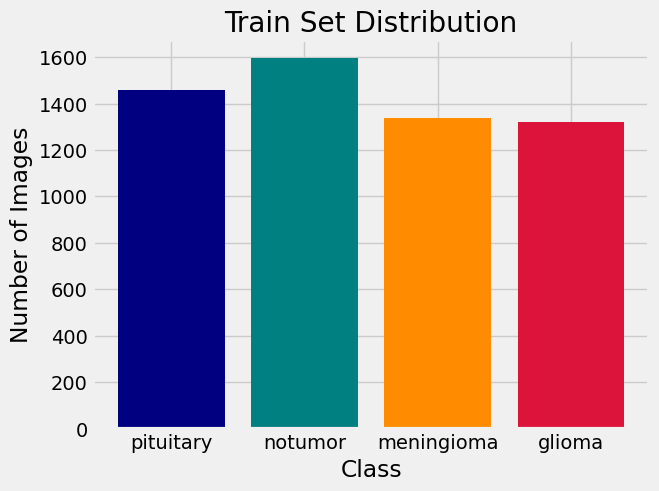

In [11]:
fig1 = plot_class_distribution(train_path, "Train")

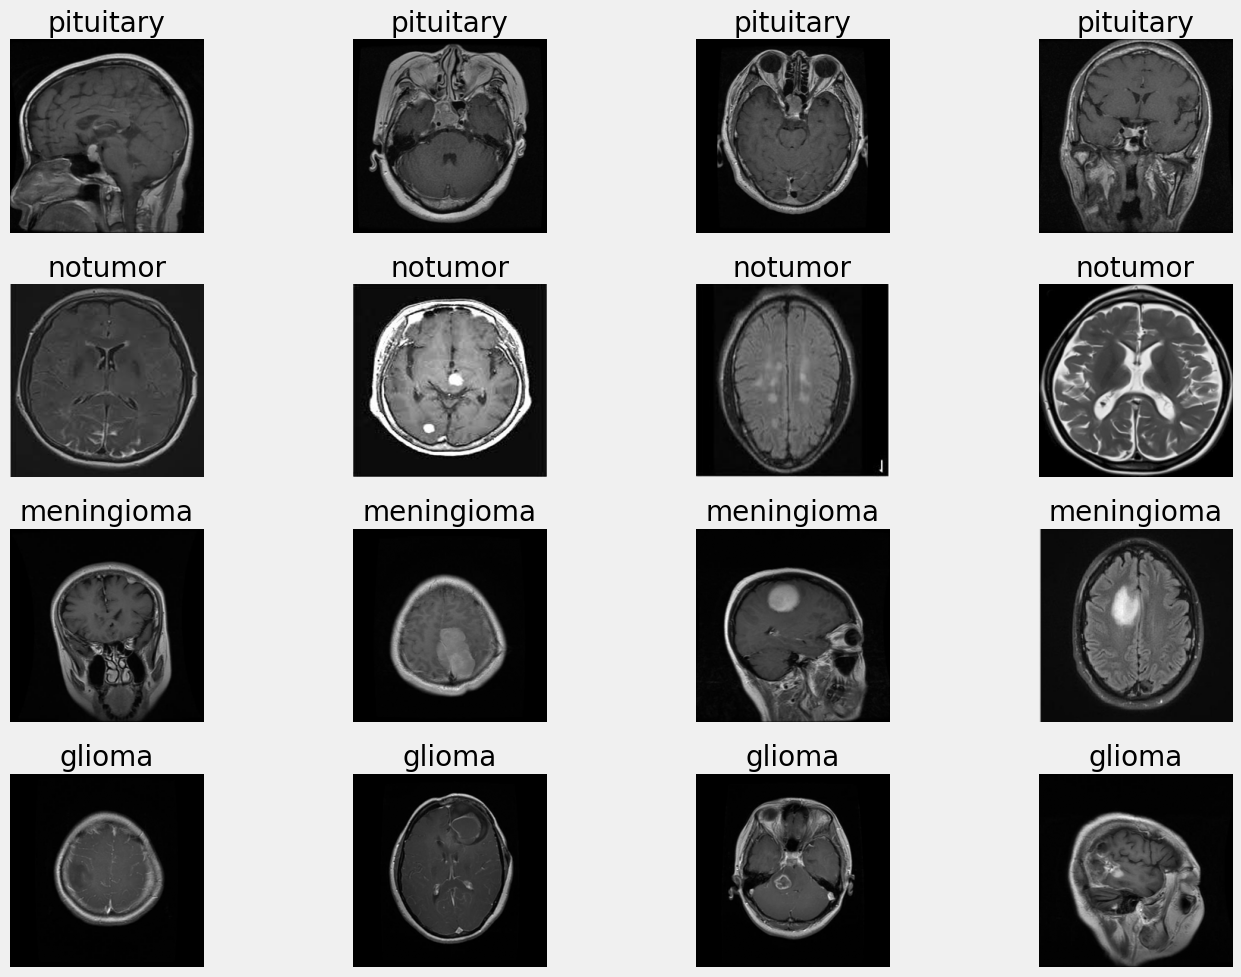

In [12]:
fig2 = display_images(train_path)

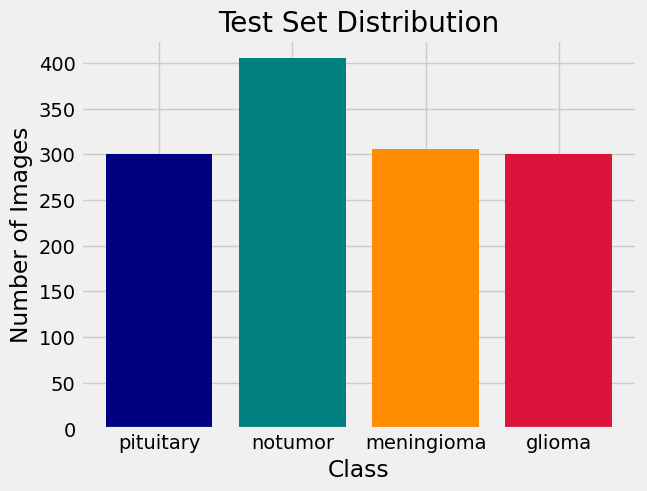

In [13]:
fig3 = plot_class_distribution(test_path, "Test")

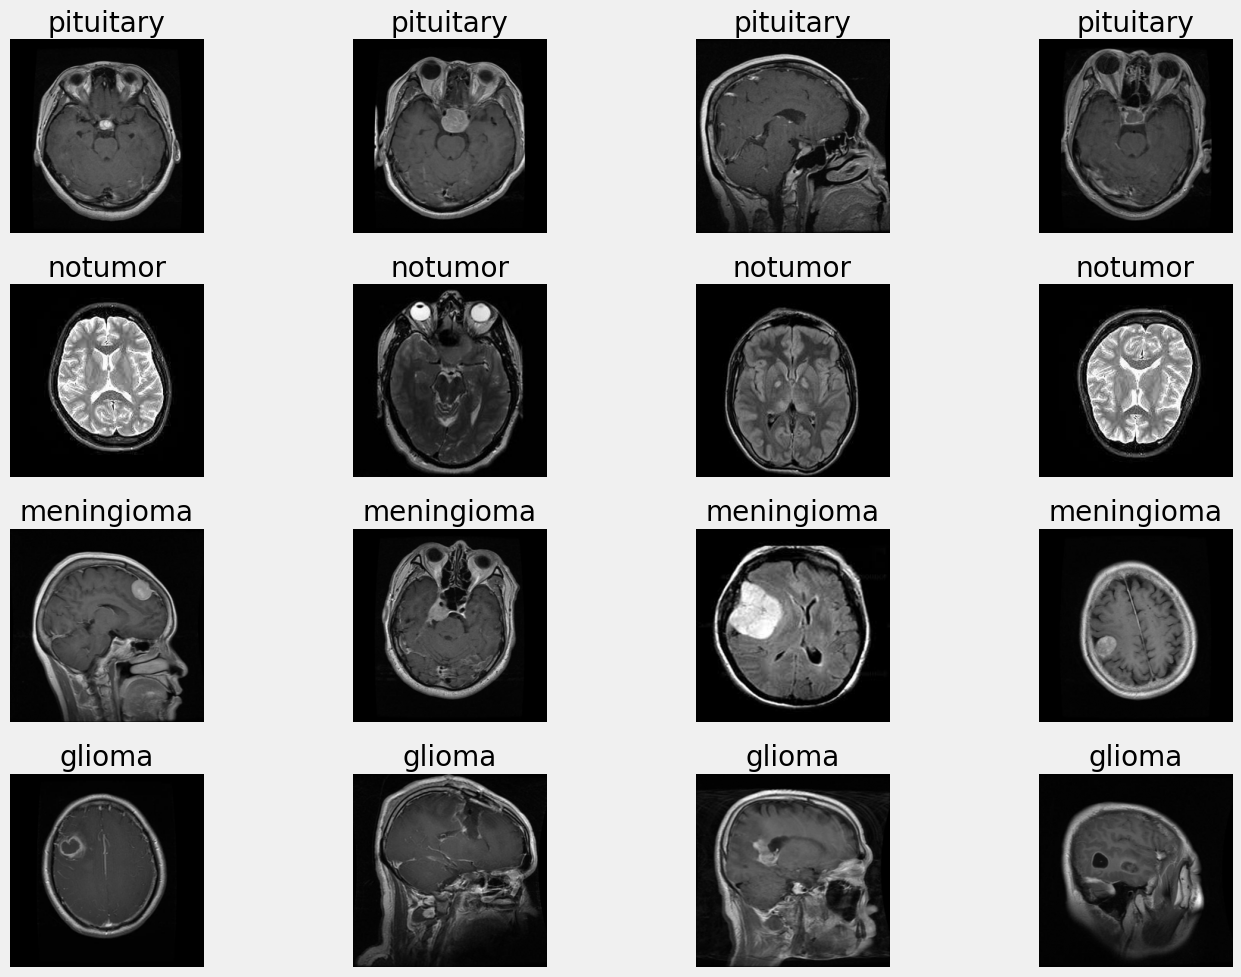

In [14]:
fig4 = display_images(test_path)

## Reading Data

In [15]:
def load_datasets(train_path, test_path, target_size=(256, 256), batch_size=32, normalizer_fn=Architecture.make_normalizer, random_state=42):
    base_transform = Compose([
        Resize(target_size),
        ToImage(),
        ToDtype(torch.float32, scale=True)
    ])

    temp_dataset = ImageFolder(root=train_path, transform=base_transform)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)
    normalizer = normalizer_fn(temp_loader)

    train_transform = Compose([
        Resize(target_size),
        RandomHorizontalFlip(),
        RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ColorJitter(brightness=(0.8, 1.2)),
        RandomRotation(10),
        ToImage(),
        ToDtype(torch.float32, scale=True),
        normalizer
    ])

    test_transform = Compose([
        Resize(target_size),
        ToImage(),
        ToDtype(torch.float32, scale=True),
        normalizer
    ])

    train_dataset = ImageFolder(root=train_path, transform=train_transform)
    temp_test_dataset = ImageFolder(root=test_path, transform=test_transform)

    val_size = len(temp_test_dataset) // 2
    test_size = len(temp_test_dataset) - val_size
    val_dataset, test_dataset = random_split(
        temp_test_dataset,
        lengths=[val_size, test_size],
        generator=torch.Generator().manual_seed(random_state)
    )

    return train_dataset, val_dataset, test_dataset, normalizer


In [16]:
train_dataset, val_dataset, test_dataset, normalizer = load_datasets(train_path, test_path)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Images

In [17]:
def unnormalize(tensor, normalizer):
    mean = torch.tensor(normalizer.mean).view(-1, 1, 1)
    std = torch.tensor(normalizer.std).view(-1, 1, 1)
    return tensor * std + mean

In [18]:
def loaded_images(images, labels, normalizer):
    titles = ['Glioma', 'Meningioma', 'NoTumor', 'Pituitary']

    fig, axs = plt.subplots(1, 6, figsize=(12, 12))

    for i in range(6):
        img_tensor = unnormalize(images[i], normalizer)
        image = ToPILImage()(img_tensor)
        label = labels[i].item()

        #image, label = ToPILImage()(images[i]), labels[i]

        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)

    fig.tight_layout()
    return fig


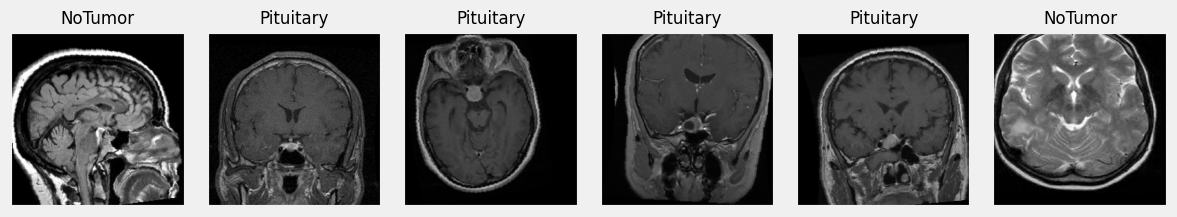

In [19]:
torch.manual_seed(42)

imagens_batch, rotulos_batch = next(iter(train_loader))
fig5 = loaded_images(imagens_batch, rotulos_batch, normalizer)

## Dropout

In [20]:
def plot_dist(ax, distrib_outputs, p):
    ax.hist(distrib_outputs, bins=np.linspace(0, 20, 21))
    ax.set_xlabel('Sum of Adjusted Outputs')
    ax.set_ylabel('# of Scenarios')
    ax.set_title('p = {:.2f}'.format(p))
    ax.set_ylim([0, 500])
    mean_value = distrib_outputs.mean()
    ax.plot([mean_value, mean_value], [0, 500], c='r', linestyle='--', label='Mean = {:.2f}'.format(mean_value))
    ax.legend()



def plot_dropout_dists(ps=(0.1, 0.3, 0.5, 0.9)):
    spaced_points = torch.linspace(.1, 1.1, 11)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, p in zip(axs.flat, ps):
        torch.manual_seed(17)
        distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                                 weight=torch.ones(11), bias=torch.tensor(0))
                                        for _ in range(1000)])
        plot_dist(ax, distrib_outputs, p)
        ax.label_outer()
    fig.tight_layout()
    return fig

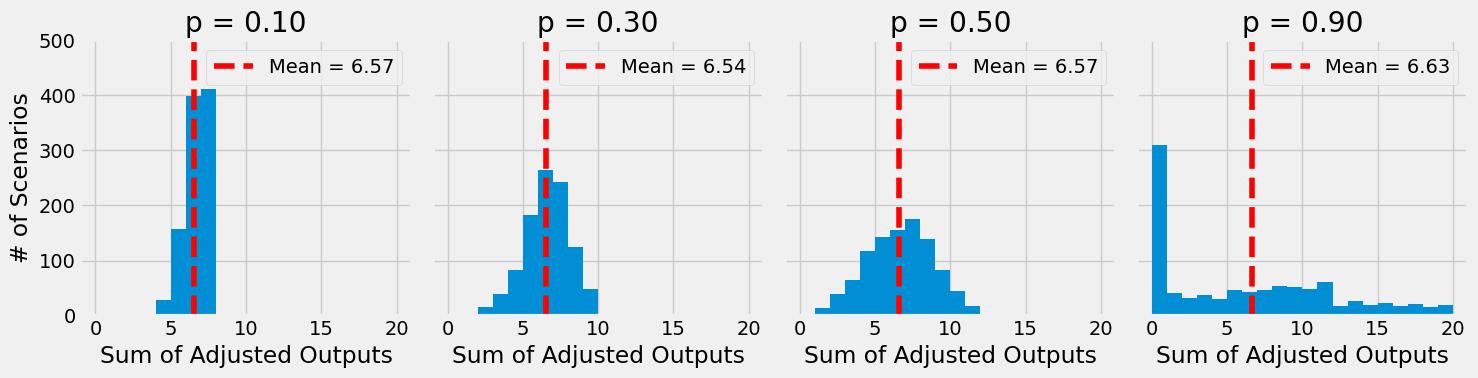

In [21]:
fig6 = plot_dropout_dists()

In [22]:
def plot_dropout_images(first_images, seed=17, p=.33, normalizer=None):
    torch.manual_seed(seed)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Apply unnormalization if normalizer is provided
    def process(image):
        return unnormalize(image, normalizer) if normalizer else image

    # Original Image
    axs[0].imshow(ToPILImage()(process(first_images[0])))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Dropout
    dropout_img = process(F.dropout(first_images[:1], p=p)[0])
    axs[1].imshow(ToPILImage()(dropout_img))
    axs[1].set_title('Regular Dropout')
    axs[1].axis('off')

    # 2D Dropout
    dropout2d_img = process(F.dropout2d(first_images[:1], p=p)[0])
    axs[2].imshow(ToPILImage()(dropout2d_img))
    axs[2].set_title('Two-Dimensional Dropout')
    axs[2].axis('off')

    fig.tight_layout()
    return fig

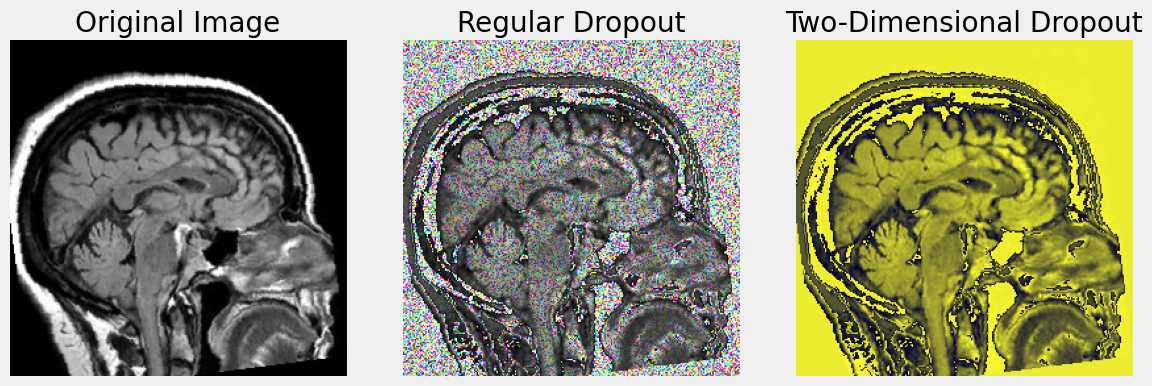

In [23]:
fig7 = plot_dropout_images(imagens_batch, p=0.3, normalizer=normalizer)

## Training a Base Model

**Architecture Overview:**

(`3, 256, 256`) → Conv → (`4, 256, 256`) → MaxPool → (`4, 128, 128`)

(`4, 128, 128`) → Conv → (`4, 128, 128`) → MaxPool → (`4, 64, 64`)

(`4, 64, 64`) → Conv → (`4, 64, 64`) → MaxPool → (`4, 32, 32`)

(`4, 32, 32`) → Conv → (`4, 32, 32`) → MaxPool → (`4, 16, 16`)

Flatten → Linear(`1024 → 32`) → Linear(`32 → 4`)

0.3 dropout probability between FC layers

**Training Summary:**
* Total parameters: 33488
* Adam Optimizer with `lr=3e-4`
* Epochs Trained: 10

**Validation Performance:**
* Last Accuracy: 0.71
* Last Precision: 0.70
* Last Recall: 0.70
* No notable overfitting.

In [53]:
class CNN0(nn.Module):
    def __init__(self, num_classes=4, p=0.3):
        super(CNN0, self).__init__()
        self.p = p

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding=1)

        # Conv Block 2
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, padding=1)

        # Conv Block 3
        self.conv3 = nn.Conv2d(4, 4, kernel_size=3, padding=1)

        # Conv Block 4
        self.conv4 = nn.Conv2d(4, 4, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def featurizer(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (3, 4, 128, 128)
        x = self.pool(self.relu(self.conv2(x)))  # (4, 4, 64, 64)
        x = self.pool(self.relu(self.conv3(x)))  # (4, 4, 32, 32)
        x = self.pool(self.relu(self.conv4(x)))  # (4, 4, 16, 16)
        x = self.flatten(x)
        return x

    def classifier(self, x):
        if self.p > 0:
            x = self.dropout(x)
        x = self.relu(self.fc1(x))

        if self.p > 0:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x


In [54]:
torch.manual_seed(13)

model_cnn0 = CNN0()

multi_loss_fn_cnn0 = nn.CrossEntropyLoss(reduction='mean')

optimizer_cnn0 = optim.Adam(model_cnn0.parameters(), lr=3e-4)

In [55]:
arch_cnn0 = Architecture(model_cnn0, multi_loss_fn_cnn0, optimizer_cnn0)
arch_cnn0.set_loaders(train_loader, val_loader)
arch_cnn0.train(10)

Val Accuracy: 48.70% | Precision: 0.56 | Recall: 0.50
Val Accuracy: 60.15% | Precision: 0.58 | Recall: 0.60
Val Accuracy: 61.68% | Precision: 0.60 | Recall: 0.62
Val Accuracy: 65.04% | Precision: 0.62 | Recall: 0.65
Val Accuracy: 67.18% | Precision: 0.64 | Recall: 0.67
Val Accuracy: 67.18% | Precision: 0.66 | Recall: 0.67
Val Accuracy: 70.23% | Precision: 0.69 | Recall: 0.70
Val Accuracy: 70.99% | Precision: 0.69 | Recall: 0.71
Val Accuracy: 69.62% | Precision: 0.67 | Recall: 0.69
Val Accuracy: 69.77% | Precision: 0.68 | Recall: 0.69


In [56]:
print(arch_cnn0.layer_parameter_counts())

{'conv1': 112, 'conv2': 148, 'conv3': 148, 'conv4': 148, 'fc1': 32800, 'fc2': 132}


In [57]:
arch_cnn0.count_parameters()

33488

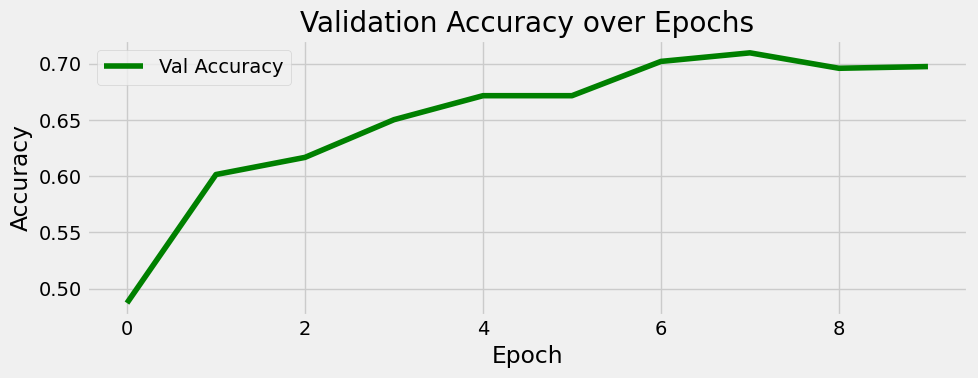

In [58]:
fig8 = arch_cnn0.plot_accuracy()

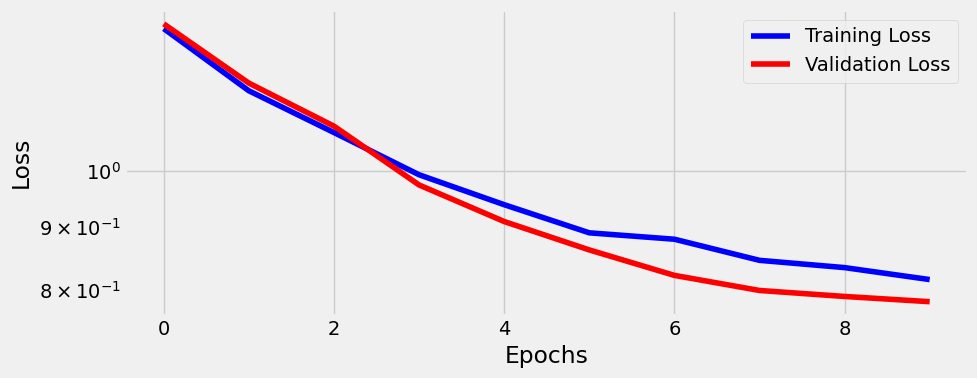

In [59]:
fig9 = arch_cnn0.plot_losses()

### **Evaluation on test set**

In [60]:
Architecture.loader_apply(test_loader,
                          arch_cnn0.correct)

tensor([[ 85, 147],
        [ 58, 149],
        [173, 210],
        [141, 150]])

In [61]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,
                                                                arch_cnn0.correct).sum(axis=0))

0.6966463414634146

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.67      0.58      0.62       147
     notumor       0.49      0.39      0.43       149
  meningioma       0.88      0.82      0.85       210
      glioma       0.66      0.94      0.77       150

    accuracy                           0.70       656
   macro avg       0.67      0.68      0.67       656
weighted avg       0.69      0.70      0.69       656



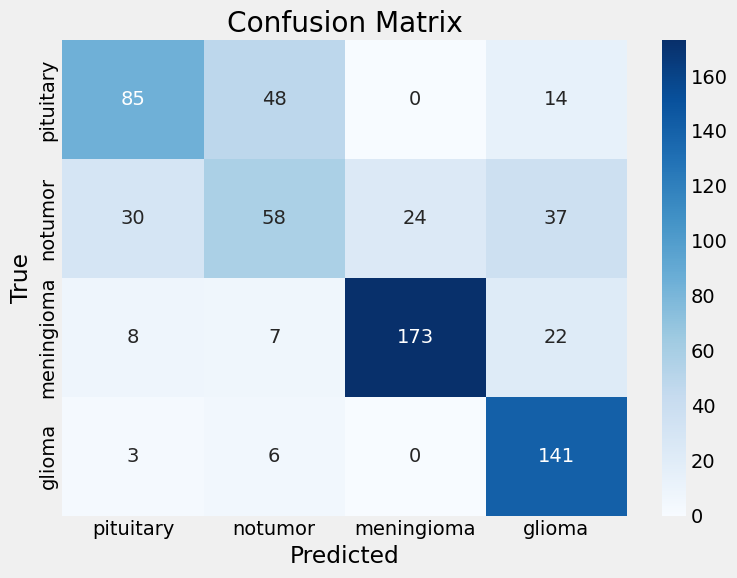

In [62]:
arch_cnn0.evaluate_on_test_set(test_loader, class_names=['pituitary', 'notumor', 'meningioma', 'glioma'])

### **Finding Learning Rate**

In [34]:
!pip install --quiet torch-lr-finder
from torch_lr_finder import LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.83E-04


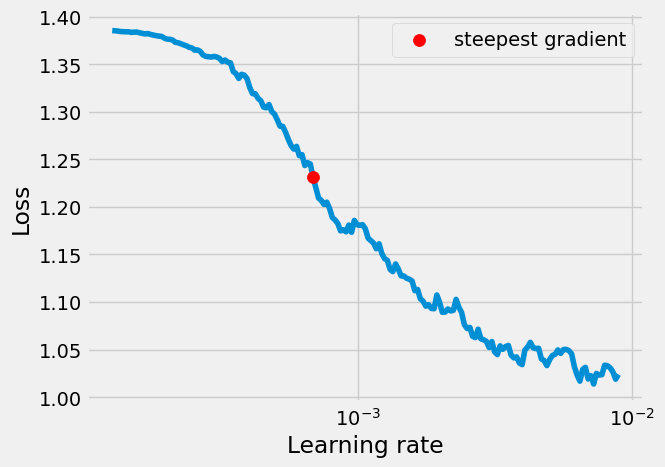

In [63]:
model = CNN0()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # lr inicial pequeno

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1e-2, num_iter=200)
lr_finder.plot()  # mostra o gráfico
lr_finder.reset()


In [64]:
torch.manual_seed(13)

model_cnn = CNN0()

multi_loss_fn_cnn = nn.CrossEntropyLoss(reduction='mean')

optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=6.83e-4)

In [65]:
arch_cnn = Architecture(model_cnn, multi_loss_fn_cnn, optimizer_cnn)
arch_cnn.set_loaders(train_loader, val_loader)
arch_cnn.train(10)

Val Accuracy: 55.57% | Precision: 0.64 | Recall: 0.55
Val Accuracy: 65.95% | Precision: 0.61 | Recall: 0.66
Val Accuracy: 68.85% | Precision: 0.67 | Recall: 0.68
Val Accuracy: 70.38% | Precision: 0.69 | Recall: 0.70
Val Accuracy: 71.15% | Precision: 0.69 | Recall: 0.70
Val Accuracy: 70.23% | Precision: 0.70 | Recall: 0.69
Val Accuracy: 71.91% | Precision: 0.71 | Recall: 0.71
Val Accuracy: 72.82% | Precision: 0.71 | Recall: 0.72
Val Accuracy: 71.15% | Precision: 0.71 | Recall: 0.70
Val Accuracy: 73.28% | Precision: 0.72 | Recall: 0.72


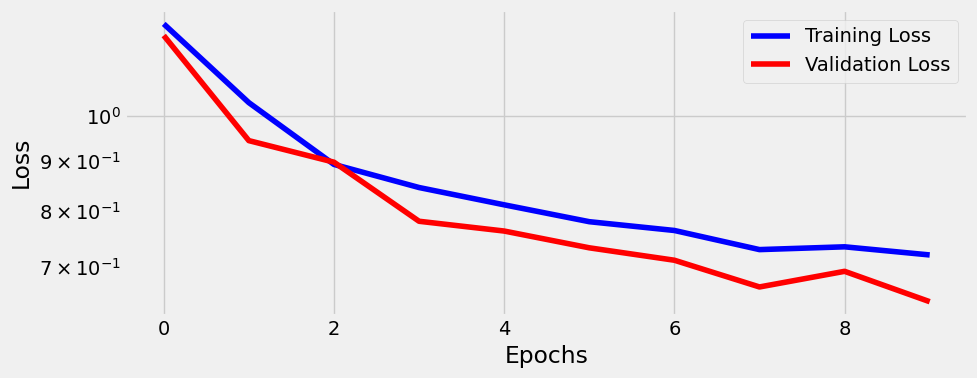

In [70]:
fig10 = arch_cnn.plot_losses()

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.78      0.63      0.70       147
     notumor       0.57      0.42      0.48       149
  meningioma       0.83      0.92      0.87       210
      glioma       0.74      0.95      0.83       150

    accuracy                           0.75       656
   macro avg       0.73      0.73      0.72       656
weighted avg       0.74      0.75      0.73       656



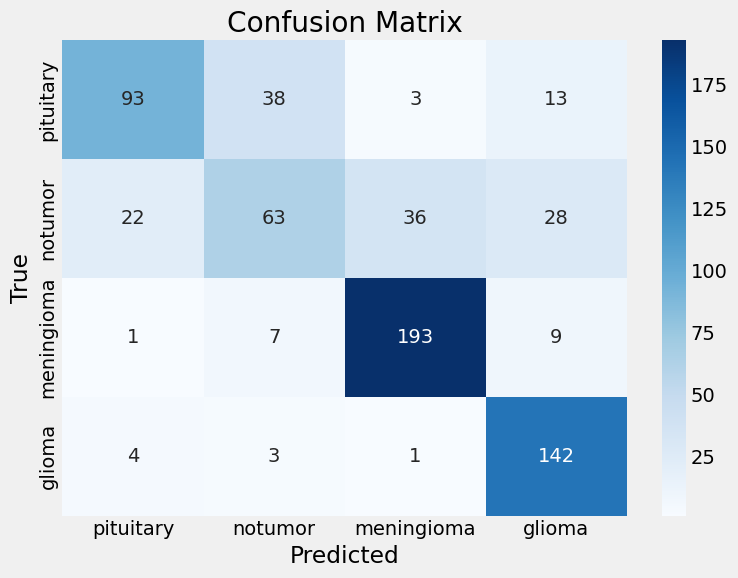

In [71]:
arch_cnn.evaluate_on_test_set(test_loader, class_names=['pituitary', 'notumor', 'meningioma', 'glioma'])